# Processamento de Imagem - SCC5830

## Aluno:
 - Victor Akihito Kamada Tomita | 10692082 | akihito012@usp.br | CCMC


obs: este notebook foi desenvolvido no google colab, por favor utilize o ambiente do colab para testar este notebook

---
# Análise de sentimentos em texto

---

Neste notebook será aplicado um fine tuning sobre o BERT para geração de embeddings do modelo multimodal. Para tal o BERT será treinado sobre o IMDB. 

Este notebook permite gerar o modelo de análise de sentimentos em texto, que por sua vez será ser utilizado no notebook <code>Video Sentiment Analisys pipeline</code> para a extração de embeddings de texto.

---
### 1 . Identificação do Problema
---
Iremos utilizar a base de dados de análise de sentimentos do IMDB, o qual é composto por 50000 instâncias de reviews de filmes, as quais estão classificadas em positivo e negativo. Dessa forma, objetivo deste dataset é classificar os vídeos nessas classes.

[link do conjunto de dados](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

---

In [ ]:
%%capture
!gdown --id 16h3AvspOm6rS-TunJvUwvvGoiLtwxExG

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set_theme()

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.copy()                        ## cap in 5000
df['review'] = df['review'].apply(lambda x: x.replace('<br /><br />', ''))
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive


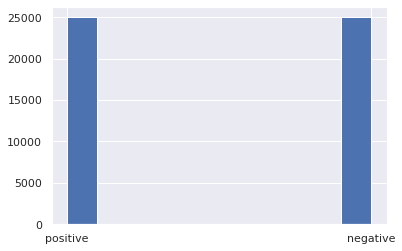

In [ ]:
df['sentiment'].hist()

---
##2) Pré-prcessamento dos dados para representação textual
---

- Text Embedding por meio do BERT - este método utiliza de encoders de transformers. Estes modelos de atenção permitem que a arquitetura possa analizar a temporalidade de ocorrência das palavras de forma mais eficiente. Isto permite uma análise semântica consistente, o que se demonstra essencial para análise de sentimentos em texto.

In [ ]:
%%capture
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import logging

In [ ]:
model = SentenceTransformer('distiluse-base-multilingual-cased')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
bert_embeddings = model.encode(df['review'].values)

---
### Adicionando mais camadas para fine tuning do modelo

Para tal, será criado um modelo de classificação de sentimentos, e a partir disso serão extraídas as embeddings das camadas intermediárias do modelo, essas embeddings intermediárias serão consideradas para os passo seguintes.

---

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dense, Add
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
import tensorflow as tf


In [ ]:


input_dim = 512
input_data = Input(shape=(input_dim,))

x0 = Dense(64, activation='relu')(input_data)
x = Dense(64, activation='relu')(x0)
x0 = Add()([x0, x])


x = Dense(64, activation='relu')(x0)
x = Dense(64, activation='relu')(x)
x0 = Add()([x0, x])

intermed_layer = Dense(64, activation='relu')(x0)
output = Dense(2, activation='softmax')(intermed_layer)

inter_model = Model(input_data, intermed_layer)

classificaiton_model = Model(input_data, output)
classificaiton_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

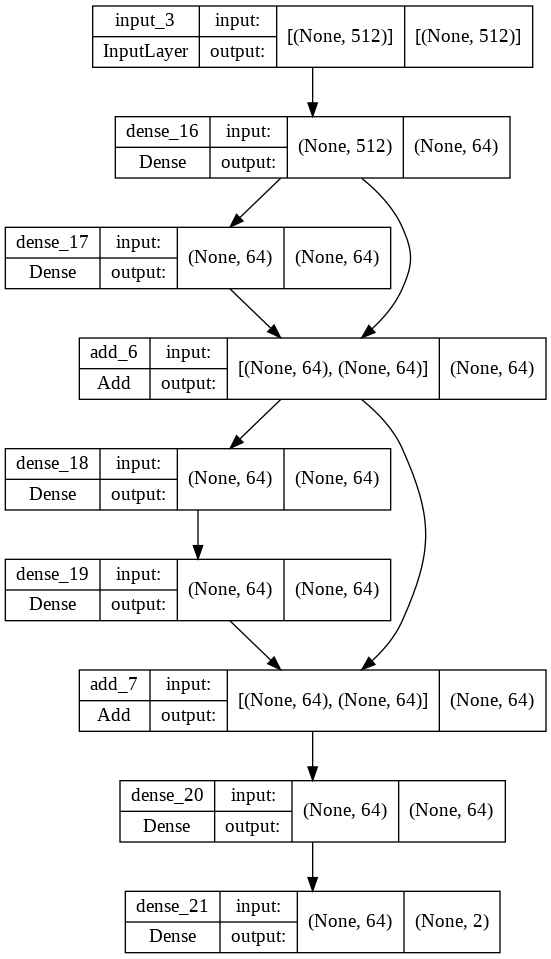

In [ ]:
plot_model(classificaiton_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
emb_train, emb_test, y_train, y_test = train_test_split(bert_embeddings, pd.get_dummies(df['sentiment']).values ,
                                                        test_size=0.2, random_state=42)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

classificaiton_model.fit(emb_train, y_train, batch_size=128, epochs=500, 
                  validation_data=(emb_test, y_test), shuffle=True, verbose=True,  callbacks=[callback])

Epoch 1/500
313/313 [==============================] - 2s 4ms/step - loss: 0.4675 - acc: 0.7764 - val_loss: 0.4341 - val_acc: 0.7923
Epoch 2/500
313/313 [==============================] - 1s 4ms/step - loss: 0.4236 - acc: 0.8008 - val_loss: 0.4259 - val_acc: 0.7925
Epoch 3/500
313/313 [==============================] - 1s 4ms/step - loss: 0.4069 - acc: 0.8119 - val_loss: 0.4195 - val_acc: 0.8014
Epoch 4/500
313/313 [==============================] - 1s 4ms/step - loss: 0.3868 - acc: 0.8245 - val_loss: 0.4275 - val_acc: 0.7996
Epoch 5/500
313/313 [==============================] - 1s 4ms/step - loss: 0.3654 - acc: 0.8359 - val_loss: 0.4254 - val_acc: 0.8003


In [ ]:
classificaiton_model.save('text_model')

INFO:tensorflow:Assets written to: text_model/assets


In [ ]:
!zip -r text_model.zip text_model/

updating: text_model/ (stored 0%)
  adding: text_model/variables/ (stored 0%)
  adding: text_model/variables/variables.index (deflated 70%)
  adding: text_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: text_model/saved_model.pb (deflated 90%)
  adding: text_model/assets/ (stored 0%)
  adding: text_model/keras_metadata.pb (deflated 91%)
